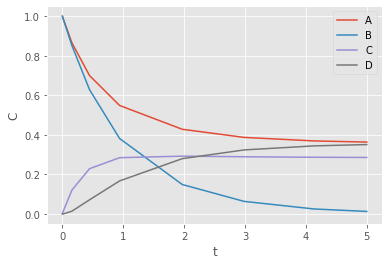

In [1]:
from scipy.integrate import solve_ivp
import numpy as np

def ode(t, C):
   
    CA, CB, CC, CD = C
    
    r1 = k1 * CA * CB
    r2 = k2 * CB* CC
    
    dA_dt = -r1
    dB_dt = -r1 - r2
    dC_dt = r1 - r2
    dD_dt = r2
    
    return [dA_dt, dB_dt, dC_dt, dD_dt ]

C0 = [1.0, 1.0, 0.0, 0.0]
k1 = 1
k2 = 1.5

sol = solve_ivp(ode, (0,5), C0)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

plt.plot(sol.t, sol.y.T);
plt.legend(['A', 'B', 'C', 'D']);
plt.xlabel('t');
plt.ylabel('C');

In [13]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    
    return x / (1.0 + np.exp(-x))

def C(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
    return outputs

# initial guess for the weights and biases
params = init_random_params(0.1, layer_sizes=[1, 10, 4])

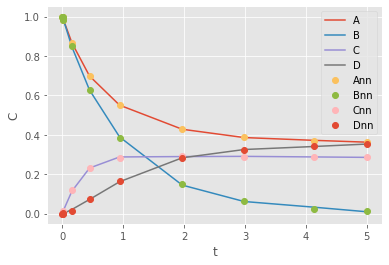

In [14]:
def objective_soln(params, step):
    return np.sum((sol.y.T - C(params, sol.t.reshape([-1, 1])))**2)

loss = []

for i in range(10):
    params = adam(grad(objective_soln), params,
                  step_size=0.001, num_iters=500)
    
    loss.append(objective_soln(params, i))

plt.plot(sol.t.reshape([-1, 1]), C(params, sol.t.reshape([-1, 1])),
         sol.t, sol.y.T, 'o')
plt.legend(['A', 'B', 'C', 'D', 'Ann', 'Bnn', 'Cnn', 'Dnn']);
plt.xlabel('t');
plt.ylabel('C');


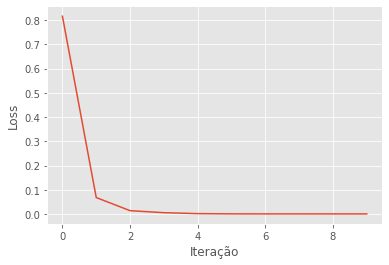

In [15]:
iter = []
for i in range(0,10):
    iter.append(i)

plt.plot(iter, loss)
plt.xlabel('Iteração');
plt.ylabel('Loss');

Text(0, 0.5, 'C')

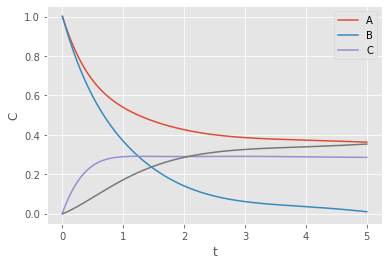

In [51]:
x = np.linspace(0,5, 500)
y = []
for i in range(len(x)):
    y.append(C(params,x[i]))
y = np.array(y)

    
plt.plot(x.reshape([-1, 1]), y[:,0])
plt.legend(['A', 'B', 'C']);
plt.xlabel('t');
plt.ylabel('C')

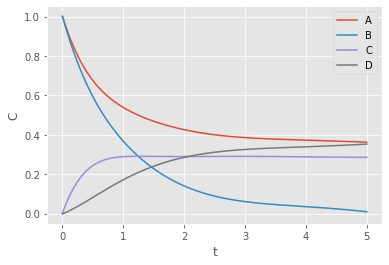

In [54]:
x = np.linspace(0,5, 500)
y = []
for i in range(len(x)):
    y.append(C(params,x[i]))
y = np.array(y)

plt.plot(x.reshape([-1, 1]), y[:,0]);
plt.legend(['A', 'B', 'C', 'D']);
plt.xlabel('t');
plt.ylabel('C');

In [11]:
# Derivatives
jac = jacobian(C, 1)

def dCdt(params, t):
    i = np.arange(len(t))
    return jac(params, t)[i, :, i].reshape((len(t), 4))

In [27]:
t = np.linspace(0, 5, 25).reshape((-1, 1))
params = init_random_params(0.1, layer_sizes=[1, 10, 4])
i = 0    # number of training steps
N = 501  # epochs for training
et = 0.0 # total elapsed time

In [28]:
def objective(params, step):
    CA, CB, CC, CD = C(params, t).T
    dA_dt, dB_dt, dC_dt, dD_dt = dCdt(params, t).T

    z1 = np.sum((dA_dt + k1*CA*CB)**2)
    z2 = np.sum((dB_dt + k1*CA*CB + k2*CB*CC)**2)
    z3 = np.sum((dC_dt - k1*CA*CB + k2*CB*CC)**2)
    z4 = np.sum((dD_dt - k2*CB*CC)**2)
    
    ic = np.sum((np.array([CA[0], CB[0], CC[0], CD[0]]) - C0)**2)  # initial conditions
    return z1 + z2 + z3 + z4 + ic

def callback(params, step, g):
    if step % 100 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))

objective(params, 0)  # make sure the objective is scalar

2.240880202103529

Iteration   0 objective 0.003031281735049852
Iteration 100 objective 0.002805404146518455
Iteration 200 objective 0.0025371491827475916
Iteration 300 objective 0.0022617443021644415
Iteration 400 objective 0.0019479917096282356
Iteration 500 objective 0.0015472696515516737

Iteration   0 objective 0.0015427684376197414
Iteration 100 objective 0.0013994231809302887
Iteration 200 objective 0.0011940433977102735
Iteration 300 objective 0.000939746294197162
Iteration 400 objective 0.0006800362084169163
Iteration 500 objective 0.0004612366812537888

Iteration   0 objective 0.000459374348234549
Iteration 100 objective 0.00038066874618475534
Iteration 200 objective 0.0003002193648890219
Iteration 300 objective 0.00023266393528786225
Iteration 400 objective 0.0001877218966657863
Iteration 500 objective 0.00016138726894790285

Iteration   0 objective 0.00016119035837083097
Iteration 100 objective 0.00015352413308384808
Iteration 200 objective 0.00014663395805299297
Iteration 300 objective 0.000

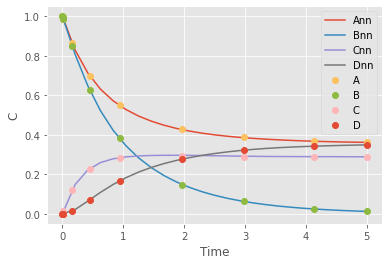

In [30]:
import time
t0 = time.time()

for i in range(5):
    
    params = adam(grad(objective), params,
                  step_size=0.001, num_iters=N, callback=callback)
    print('')

i += N
t1 = (time.time() - t0) / 60
et += t1

plt.plot(t, C(params, t), sol.t, sol.y.T, 'o')
plt.legend(['Ann', 'Bnn', 'Cnn', 'Dnn', 'A', 'B', 'C', 'D'])
plt.xlabel('Time')
plt.ylabel('C')